## LSTM for t=1 to t=20
* train best model from from model selection (see 'LNP_LSTM_model_selection')
* seperate model for each prediction model (classification or regression) and each cross-validation fold
* save out predictions on the test data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import glob

In [4]:
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [6]:
def plot_history(model_history, model_name, fit_method):
    if fit_method == 'classify':
        fig = plt.figure(figsize=(15,5), facecolor='w')
        ax = fig.add_subplot(121)
        ax.plot(model_history.history['loss'])
        ax.plot(model_history.history['val_loss'])
        ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
        ax.legend(['Train', 'Test'], loc='upper right')
        ax = fig.add_subplot(122)
        ax.plot(model_history.history['acc'])
        ax.plot(model_history.history['val_acc'])
        ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
        ax.legend(['Train', 'Test'], loc='upper right')
    else:
        fig = plt.figure(figsize=(8,5), facecolor='w')
        ax = fig.add_subplot(111)
        ax.plot(model_history.history['loss'])
        ax.plot(model_history.history['val_loss'])
        ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
        ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

### Settings

In [7]:
fold = 'fold5'
fit_method = 'regress' # clasify or regress

n_epochs = 30
batch_size = 32
n_time = 20
n_latent = 32
lr = 0.00001

save_best = keras.callbacks.ModelCheckpoint('best.weights', monitor='val_loss', verbose=0, save_best_only=True)

res_df = pd.read_csv('/scratch-shared/phil/LNP/LNP_data_09/LSTM_model_selection_' + fit_method  + '_' + fold + '.csv')
res_df = res_df.sort_values(ascending=True, by='val_loss')
res_df = res_df.reset_index()

layer_0 = int(res_df['layer_0'][0])
layer_1 = int(res_df['layer_1'][0])
layer_2 = int(res_df['layer_2'][0])
layer_end = int(res_df['layer_end'][0])

rec_do = res_df['rec_do'][0]
main_do = res_df['main_do'][0]
end_do = res_df['end_do'][0]

train_ts = np.load('/scratch-shared/phil/LNP/LNP_data_09/train_ts_' + fit_method + '_' + fold + '.npy')
train_y = np.load('/scratch-shared/phil/LNP/LNP_data_09/train_cell_gfp_' + fit_method + '_' + fold + '.npy')
train_ids = np.load('/scratch-shared/phil/LNP/LNP_data_09/train_cell_ids_' + fit_method + '_' + fold + '.npy')

train_index = []
valid_index = []

for i in range(len(train_ids)):
    s0 = train_ids[i].split('train/')
    s1 = s0[1].split('_')[0]
    if s1 == fold:
        valid_index.append(i)
    else:
        train_index.append(i)

train_ts_train = train_ts[train_index]
train_y_train = train_y[train_index]
train_ts_valid = train_ts[valid_index]
train_y_valid = train_y[valid_index]


# getting class weights for when in classification mode
if fit_method == 'classify':
    class_gfp = train_y_train.astype('int64')
    weights = class_weight.compute_class_weight('balanced', np.unique(class_gfp), class_gfp)
    print('weights = ' + str(weights))

### Train model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 8,353
Trainable params: 8,353
Non-trainable params: 0
_________________________________________________________________
None
Train on 3728 samples, validate on 1088 samples
Epoch 1/30
 - 10s - loss: 1.7361 - val_loss: 1.3107
Epoch 2/30
 - 7s - loss: 1.5504 - val_loss: 1.1577
Epoch 3/30
 - 7s - loss: 1.3842 - val_loss: 1.0217
Epoch 4/30
 - 7s - loss: 1.2334 - val_loss: 0.9010
Epoch 5/30
 - 7s - loss: 1.0943 - val_loss: 0.7958
Epoch 6/30
 - 6s - loss: 0.9729 - val_loss: 0.7057
Epoch 7/30
 - 6s - loss: 0.8675 - val_loss: 

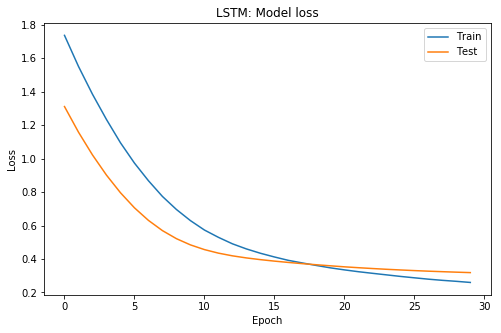

In [8]:
input_ts = Input(shape=(n_time, n_latent))
x = input_ts

if layer_0 != 0:
    x = Bidirectional(LSTM(layer_0, dropout=main_do, recurrent_dropout=rec_do,
                           input_shape=(n_time, n_latent)))(x)
else:
    if layer_2 != 0:
        x = LSTM(layer_1, dropout=main_do, recurrent_dropout=rec_do,
                 return_sequences=True,
                 input_shape=(n_time, n_latent))(x)
        x = LSTM(layer_2, dropout=main_do, recurrent_dropout=rec_do)(x)
    else:
        x = LSTM(layer_1, dropout=main_do, recurrent_dropout=rec_do,
                 input_shape=(n_time, n_latent))(x)

if layer_end != 0:
    x = Dense(layer_end, activation='relu')(x)
    x = Dropout(end_do)(x)

if fit_method == 'classify': 
    x = Dense(1, activation='sigmoid')(x)
else:
    x = Dense(1)(x)

model = Model(input_ts, x)
print(model.summary())

if fit_method == 'classify':
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(
        train_ts_train, train_y_train,
        steps_per_epoch=len(train_ts_train) // batch_size,
        epochs = n_epochs,
        shuffle = True,
        validation_data = (train_ts_valid, train_y_valid),
        validation_steps = len(train_ts_valid) // batch_size,
        callbacks = [save_best],
        class_weight = weights,
        verbose = 2
    )
else:
    model.compile(optimizer=Adam(lr=lr), loss='mse')
    history = model.fit(
        train_ts_train, train_y_train,
        steps_per_epoch=len(train_ts_train) // batch_size,
        epochs = n_epochs,
        shuffle = True,
        validation_data = (train_ts_valid, train_y_valid),
        validation_steps = len(train_ts_valid) // batch_size,
        callbacks = [save_best],
        verbose = 2
    )

plot_history(history, 'LSTM', fit_method)

model.save('/scratch-shared/phil/LNP/LNP_data_09/LSTM_' + fit_method + '_lr_00001_' + fold + '.h5')

### Save predictions for test data

In [9]:
test_ts = np.load('/scratch-shared/phil/LNP/LNP_data_09/test_ts_' + fit_method + '_' + fold + '.npy')
test_y = np.load('/scratch-shared/phil/LNP/LNP_data_09/test_cell_gfp_' + fit_method + '_' + fold + '.npy')
test_ids = np.load('/scratch-shared/phil/LNP/LNP_data_09/test_cell_ids_' + fit_method + '_' + fold + '.npy')

test_pred = model.predict(test_ts)
np.save('/scratch-shared/phil/LNP/LNP_data_09/test_pred_' + fit_method + '_lr_00001_' + fold + '.npy', test_pred)

print('rmse = ' + str(np.round(np.sqrt(mean_squared_error(test_y, test_pred)), decimals=3)))

rmse = 0.612
